In [1]:
#configurando o ambiente

! pip install tensorflow==2.1.2
! pip install keras==2.3.0
! pip uninstall h5py -y
! pip install 'h5py<3.0.0'

     |████████████████████████████████| 421.8 MB 22 kB/s 
     |████████████████████████████████| 41 kB 639 kB/s 
     |████████████████████████████████| 50 kB 5.2 MB/s 
     |████████████████████████████████| 448 kB 49.6 MB/s 
     |████████████████████████████████| 3.8 MB 20.5 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=a25529d292e83a26a960cd1d80770863c5dd9b0ad2005a0fdc3564e21a1a0efb
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstal

     |████████████████████████████████| 377 kB 5.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 5.1 MB/s 


In [2]:
%cd "/content/drive/MyDrive/UNB/4° SEMESTRE (EaD)/EIA - Estudos em inteligência artificial/CNN"

/content/drive/MyDrive/UNB/4° SEMESTRE (EaD)/EIA - Estudos em inteligência artificial/CNN


In [3]:
#importando as bibliotecas necessarias

import cv2
import os
import numpy as np
import random
import colorsys
import argparse
import time
from mrcnn import model as modellib
from mrcnn import visualize
from coco.coco import CocoConfig
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline

Using TensorFlow backend.


In [4]:
class MyConfig(CocoConfig): #sobrescrevendo as configuracoes do COCO com as minhas
    NAME = "my_coco_inference"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [5]:
def prepare_mrcnn_model(model_path, model_name, class_names, my_config):
    classes = open(class_names).read().strip().split("\n")
    print("No. of classes", len(classes))

    hsv = [(i / len(classes), 1, 1.0) for i in range(len(classes))]
    COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.seed(42)
    random.shuffle(COLORS) #separa a quantidade de cores necessarias

    model = modellib.MaskRCNN(mode="inference", model_dir=model_path, config=my_config) #instancia o Mask RCNN
    model.load_weights(model_name, by_name=True) #carregas os pesos ja treinados para dentro do modelo

    return COLORS, model, classes

In [6]:
def perform_inference_image(image_path, model, colors, classes, draw_bbox, instance_segmentation):
    test_image = cv2.imread(image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    output = custom_visualize(test_image, model, colors, classes, draw_bbox, instance_segmentation)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    return output

In [7]:
def custom_visualize(test_image, model, colors, classes, draw_bbox, instance_segmentation):
    detections = model.detect([test_image])[0]

    if instance_segmentation:
        hsv = [(i / len(detections['rois']), 1, 1.0) for i in range(len(detections['rois']))]
        colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
        random.seed(42)
        random.shuffle(colors)

    for i in range(0, detections["rois"].shape[0]):
        classID = detections["class_ids"][i]

        mask = detections["masks"][:, :, i]
        if instance_segmentation:
            color = colors[i][::-1]
        else:
            color = colors[classID][::-1]

        # To visualize the pixel-wise mask of the object
        test_image = visualize.apply_mask(test_image, mask, color, alpha=0.5)

    test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
    
    if draw_bbox==True:
        for i in range(0, len(detections["scores"])):
            (startY, startX, endY, endX) = detections["rois"][i]

            classID = detections["class_ids"][i]
            label = classes[classID]
            score = detections["scores"][i]

            if instance_segmentation:
                color = [int(c) for c in np.array(colors[i]) * 255]

            else:
                color = [int(c) for c in np.array(colors[classID]) * 255]

            cv2.rectangle(test_image, (startX, startY), (endX, endY), color, 2)
            text = "{}: {:.2f}".format(label, score)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(test_image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            print("{},".format(text), end=" ")

    return test_image

No. of classes 81
giraffe: 1.00, zebra: 1.00, zebra: 1.00, zebra: 1.00, 

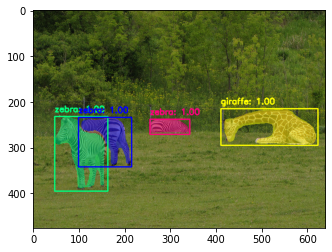

In [9]:
model_path = "models/"; model_name = "models/mask_rcnn_coco.h5"; class_names = "coco/coco_classes.txt"; image = "./test_image.jpg"

my_config = MyConfig()
# my_config.display()

colors, model, classes = prepare_mrcnn_model(model_path, model_name, class_names, my_config)
output = perform_inference_image(image, model, colors, classes, draw_bbox = True, instance_segmentation = True)

# plt.imsave("result.png", output)
plt.imshow(output)
plt.show()